# **Part A**
Count / Frequency based Naive Bayes Classifier

=== Custom Multinomial Naive Bayes (Scratch Implementation) ===
Accuracy: 0.7964
Macro F1 Score: 0.7331

Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.63      0.61      0.62      3621
 CONCLUSIONS       0.69      0.75      0.72      4571
     METHODS       0.85      0.91      0.88      9897
   OBJECTIVE       0.63      0.54      0.58      2333
     RESULTS       0.89      0.83      0.86      9713

    accuracy                           0.80     30135
   macro avg       0.74      0.73      0.73     30135
weighted avg       0.80      0.80      0.80     30135



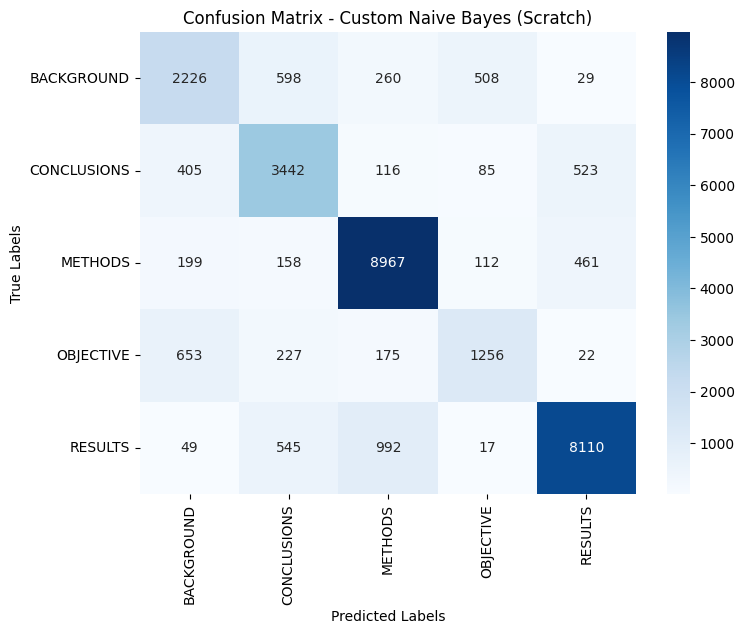

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)


# Completed: Task A - Custom Multinomial Naive Bayes


# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            #  Calculate log prior log(P(C))
            class_prior = np.log(X_c.shape[0] / X_counts.shape[0])
            self.class_priors[c] = class_prior

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            #  Laplace Smoothing
            numerator = feature_sum + self.alpha
            denominator = total_mass + self.alpha * self.vocabulary_size

            #  Log likelihoods log(P(w_i|C))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                #  Accumulate log probabilities
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            #  Class with max log-probability
            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        #  Return predictions
        return np.array(y_pred)



# Section 2: Data Loading

train_df = load_pubmed_rct_file("train.txt")
dev_df = load_pubmed_rct_file("dev.txt")
test_df = load_pubmed_rct_file("test.txt")

X_train, y_train = train_df["sentence"], train_df["label"]
X_dev, y_dev = dev_df["sentence"], dev_df["label"]
X_test, y_test = test_df["sentence"], test_df["label"]

# Section 3a: Count Vectorization

vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=2)
X_train_counts = vectorizer.fit_transform(X_train)
X_dev_counts = vectorizer.transform(X_dev)
X_test_counts = vectorizer.transform(X_test)


# Section 3b: Model Training

nb_model = NaiveBayesClassifier(alpha=1.0)
nb_model.fit(X_train_counts, y_train)


# Section 4: Evaluation

y_pred = nb_model.predict(X_test_counts)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print("=== Custom Multinomial Naive Bayes (Scratch Implementation) ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1 Score: {f1:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Custom Naive Bayes (Scratch)")
plt.show()


In [4]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [5]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # // TODO: Set appropriate ngram_range
        ngram_range=(1, 2),
        # // TODO: Set appropriate min_df
        min_df=2
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # // TODO: Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # // TODO: Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # // TODO: Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # // TODO: Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")


Fitting Count Vectorizer and transforming training data...
Vocabulary size: 301234
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [6]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# // TODO: Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7571
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.56      0.57      3621
 CONCLUSIONS       0.63      0.69      0.66      4571
     METHODS       0.81      0.89      0.85      9897
   OBJECTIVE       0.60      0.43      0.50      2333
     RESULTS       0.87      0.80      0.84      9713

    accuracy                           0.76     30135
   macro avg       0.70      0.68      0.68     30135
weighted avg       0.76      0.76      0.75     30135

Macro-averaged F1 score: 0.6825


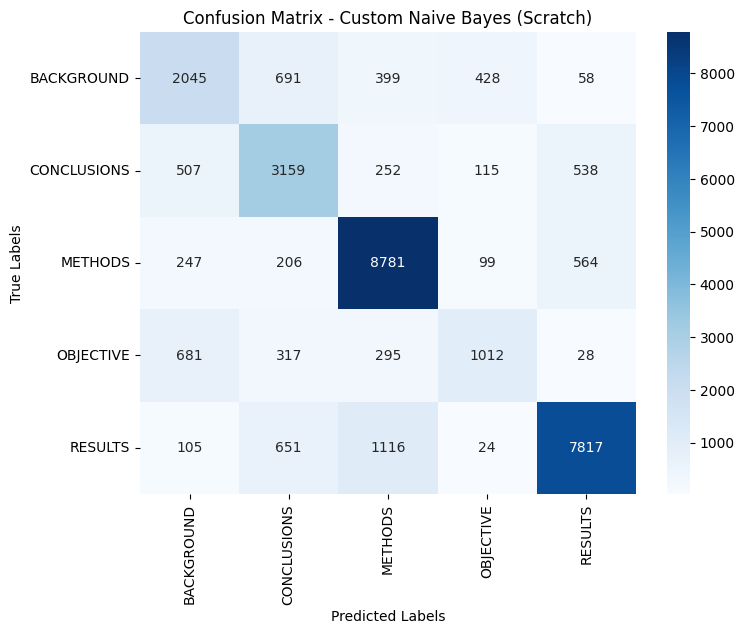

In [7]:
# Confusion Matrix on test set
# // TODO: Use the confusion_matrix, matplotlib, and seaborn libraries to generate
# a visual confusion matrix (heatmap) for the predicted results.
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix - Custom Naive Bayes (Scratch)")
    plt.show()


# **Part B**
TF-IDF score based Classifier

Train samples: 180040 | Dev samples: 30212 | Test samples: 30135
Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.6996
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.37      0.46      3621
 CONCLUSIONS       0.61      0.55      0.57      4571
     METHODS       0.68      0.88      0.77      9897
   OBJECTIVE       0.72      0.09      0.16      2333
     RESULTS       0.77      0.85      0.81      9713

    accuracy                           0.70     30135
   macro avg       0.68      0.55      0.56     30135
weighted avg       0.69      0.70      0.67     30135

Macro-averaged F1 score: 0.5555

Starting Hyperparameter Tuning on Development Set...
Grid search complete.
Best Parameters: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}
Best Cross-Validation F1 Score: 0.5925

=== Test Set Evaluation (Best Tuned Model) ===
Accuracy: 0.6927
              precision    recall  f1-

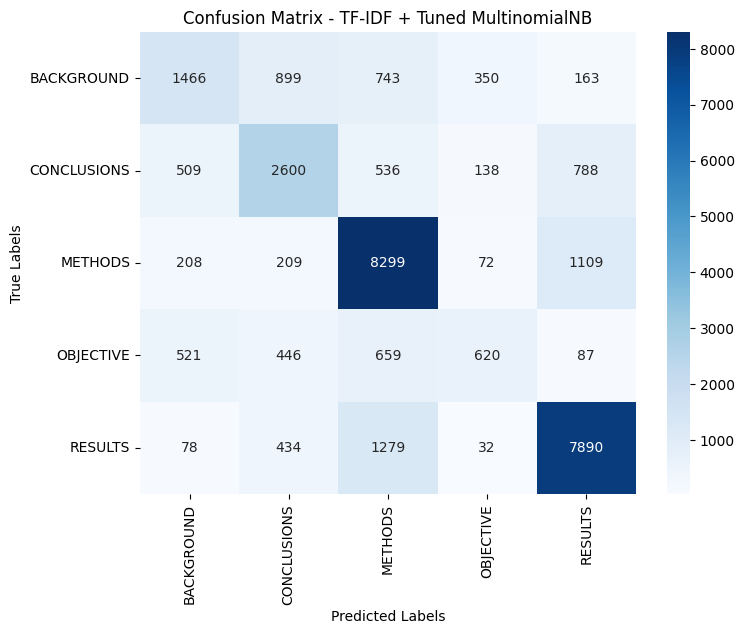

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)


# Ensure Data Is Loaded (reuses X_train, y_train, X_dev, y_dev, X_test, y_test)

if X_train is None or len(X_train) == 0:
    print("Error: Dataset not found or empty. Please load 'train.txt', 'dev.txt', and 'test.txt'.")
else:
    print(f"Train samples: {len(X_train)} | Dev samples: {len(X_dev)} | Test samples: {len(X_test)}")

# 1. Define the TF-IDF + MultinomialNB Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])


# 2. Train the initial pipeline on the training set

print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")

# 3. Predict and evaluate on test set

print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")


# 4. Hyperparameter Tuning using GridSearchCV

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)

print("\nStarting Hyperparameter Tuning on Development Set...")
grid.fit(X_dev, y_dev)
print("Grid search complete.")


# 5. Display Best Parameters and Score

if grid is not None and hasattr(grid, 'best_params_'):
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best Cross-Validation F1 Score: {grid.best_score_:.4f}")
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")


# 6. Evaluate Best Model on Test Set

print("\n=== Test Set Evaluation (Best Tuned Model) ===")
best_model = grid.best_estimator_
y_test_pred_best = best_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_test_pred_best):.4f}")
print(classification_report(y_test, y_test_pred_best, target_names=target_names))
print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred_best, average='macro'):.4f}")


# 7. Confusion Matrix Visualization for Best Model

cm = confusion_matrix(y_test, y_test_pred_best, labels=target_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - TF-IDF + Tuned MultinomialNB")
plt.show()


# **Part C**
Bayes Optimal Classifier

Part C Draft

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS334
Using dynamic sample size: 10334
Actual sampled training set size used: 10334

Training all base models...
Trained NaiveBayes on sampled data (initial fit).


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Trained LogisticRegression on sampled data (initial fit).
Trained RandomForest on sampled data (initial fit).
Trained DecisionTree on sampled data (initial fit).
Trained KNN on sampled data (initial fit).
All base models trained.

Computing validation log-likelihoods for each hypothesis...
NaiveBayes: validation log-likelihood = -2007.4710


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression: validation log-likelihood = -1861.8850
RandomForest: validation log-likelihood = -2067.7736
DecisionTree: validation log-likelihood = -2607.3625
KNN: validation log-likelihood = -2992.8194

Posterior weights (normalized):
NaiveBayes: 0.0000
LogisticRegression: 1.0000
RandomForest: 0.0000
DecisionTree: 0.0000
KNN: 0.0000

Refitting all base models on the full sampled training data...
Refitted NaiveBayes.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Refitted LogisticRegression.
Refitted RandomForest.
Refitted DecisionTree.
Refitted KNN.

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7091
Macro F1 Score: 0.6147

Classification Report:

              precision    recall  f1-score   support

  BACKGROUND       0.55      0.37      0.44      3621
 CONCLUSIONS       0.61      0.56      0.58      4571
     METHODS       0.71      0.89      0.79      9897
   OBJECTIVE       0.66      0.35      0.45      2333
     RESULTS       0.80      0.81      0.80      9713

    accuracy                           0.71     30135
   macro avg       0.66      0.60      0.61     30135
weighted avg       0.70      0.71      0.69     30135



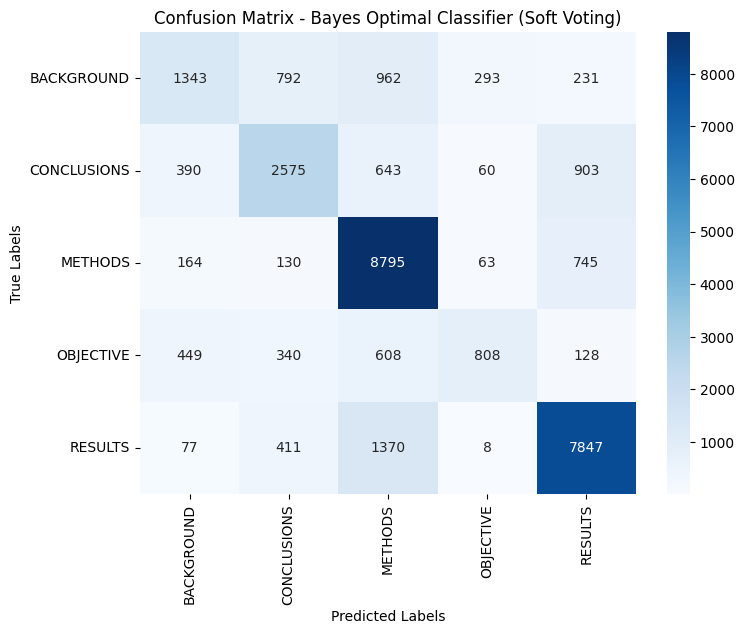

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # Used for P(h|D) calculation


# (The top part of your file up to hypotheses definitions is unchanged)


# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000

# Prompt the user for their full SRN
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    # Extract the last three characters and convert to integer
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        # Fallback if input is too short
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    # Fallback if SRN is not entered or format is incorrect
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

# Calculate the final sample size: 10000 + last three SRN digits
SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")


# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1), # Using unigrams only to keep feature space small for diverse models
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines (DO NOT CHANGE)

# H1: Multinomial Naive Bayes
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

# H2: Logistic Regression
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

# H3: Random Forest Classifier
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])

# H4: Decision Tree Classifier
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

# H5: K-Nearest Neighbors
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']


# Training and BOC Implementation (STUDENT TASK)

# // TODO: Train all five hypotheses on X_train_sampled and y_train_sampled using a for loop.
print("\nTraining all base models...")
for name, model in zip(hypothesis_names, hypotheses):
    # Fit whole sampled set initially to ensure pipelines are ready (this fit will be overwritten below when we refit)
    # We do a fit here so that any heavy TF-IDF vocabulary building happens at least once (optional)
    try:
        model.fit(X_train_sampled, y_train_sampled)
        print(f"Trained {name} on sampled data (initial fit).")
    except Exception as e:
        print(f"Initial fit warning for {name}: {e}")
print("All base models trained.")

# // TODO: Implement the Posterior Weight Calculation (P(h_i | D)).
# This requires splitting X_train_sampled into a small train_sub/val_sub set
# and calculating the validation log-likelihood for each model. Normalize these to get posterior_weights.

# Create a sub-train / validation split for computing validation log-likelihoods
train_sub_X, val_X, train_sub_y, val_y = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, stratify=y_train_sampled if len(np.unique(y_train_sampled))>1 else None, random_state=42
)

log_likelihoods = []
print("\nComputing validation log-likelihoods for each hypothesis...")

# fit on train_sub and evaluate on val set
for name, model in zip(hypothesis_names, hypotheses):
    # clone-like behavior: re-fit model on train_sub
    try:
        model.fit(train_sub_X, train_sub_y)
    except Exception as e:
        # if a fitting fails, skip and assign very low likelihood
        print(f"Error fitting {name} on train_sub: {e}")
        log_likelihoods.append(-1e12)
        continue

    # get predicted probabilities on validation set
    try:
        probs = model.predict_proba(val_X)  # shape (n_val, n_classes)
    except Exception as e:
        # if predict_proba not available, fallback to using decision_function (not expected here)
        print(f"Error during predict_proba for {name}: {e}")
        log_likelihoods.append(-1e12)
        continue

    # Map val_y labels to class indices consistent with probs' columns
    # We need to find the column order of classes returned by the estimator
    if hasattr(model.named_steps['clf'], 'classes_'):
        clf_classes = model.named_steps['clf'].classes_
    else:
        # If pipeline wraps classifier differently, attempt to fetch classes_ from the pipeline
        clf_classes = model.classes_ if hasattr(model, 'classes_') else np.unique(train_sub_y)

    # Build a mapping from label -> index
    class_to_index = {label: idx for idx, label in enumerate(clf_classes)}

    # For labels not present in clf_classes, we'll assign a tiny probability to avoid log(0)
    tiny = 1e-12
    n_val = len(val_X)
    # For each sample, get probability assigned to the true label
    log_prob_sum = 0.0
    for i, true_label in enumerate(val_y):
        idx = class_to_index.get(true_label, None)
        if idx is None or idx >= probs.shape[1]:
            p_true = tiny
        else:
            p_true = max(probs[i, idx], tiny)
        log_prob_sum += np.log(p_true)
    log_likelihoods.append(log_prob_sum)
    print(f"{name}: validation log-likelihood = {log_prob_sum:.4f}")

# Convert log-likelihoods to posterior weights (assuming equal prior for each hypothesis)
log_likelihoods = np.array(log_likelihoods, dtype=np.float64)

# Numerical stabilization: subtract max before exp
max_ll = np.max(log_likelihoods)
exp_vals = np.exp(log_likelihoods - max_ll)
posterior_weights = exp_vals / np.sum(exp_vals)

print("\nPosterior weights (normalized):")
for name, w in zip(hypothesis_names, posterior_weights):
    print(f"{name}: {w:.4f}")

# Refit all five hypotheses on the full sampled training set
print("\nRefitting all base models on the full sampled training data...")
for name, model in zip(hypothesis_names, hypotheses):
    try:
        model.fit(X_train_sampled, y_train_sampled)
        print(f"Refitted {name}.")
    except Exception as e:
        print(f"Error refitting {name}: {e}")

# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

# BOC is approximated using soft voting with posterior weights
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights.tolist(),
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
# // TODO: Fit the VotingClassifier using the full sampled training data (X_train_sampled, y_train_sampled)
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")


# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
# // TODO: Predict y_pred using X_test, and then calculate and visualize evaluation metrics.
try:
    y_pred = boc_soft_voter.predict(X_test)
except Exception as e:
    print(f"Error predicting with BOC voter: {e}")
    y_pred = None


# Final Evaluation (STUDENT TASK)
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None:
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1 Score: {f1:.4f}\n")
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Confusion Matrix
    labels_for_cm = target_names if len(target_names) > 0 else sorted(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=labels_for_cm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_for_cm, yticklabels=labels_for_cm)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix - Bayes Optimal Classifier (Soft Voting)")
    plt.show()
else:
    print("Evaluation skipped: Predictions not generated.")
